# <a id='toc1_'></a>[No VRAM Use Analysis](#toc0_)
This notebook generates the analysis for jobs run on partitions that their type is GPU but do not use any VRAM. It looks at these jobs, corresponding users, and PI groups.

**Table of contents**<a id='toc0_'></a>    
- [No VRAM Use Analysis](#toc1_)    
  - [Load the data](#toc1_1_)    
  - [Setup](#toc1_2_)    
    - [Generate all metrics used for analysis:](#toc1_2_1_)    
    - [Job Metrics](#toc1_2_2_)    
      - [Find most inefficient jobs with no VRAM constraints based on `vram_hours`](#toc1_2_2_1_)    
    - [User Metrics](#toc1_2_3_)    
      - [Find Inefficient Users based on `vram_hours`](#toc1_2_3_1_)    
    - [PI Group Metrics](#toc1_2_4_)    
      - [Find Inefficient PIs based on `vram_hours`](#toc1_2_4_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Load the data](#toc0_)

In [ ]:
# Import required modules
import sys
from pathlib import Path
import pandas as pd

Jupyter server should be run at the notebook directory, so the output of the following cell would be the project root:

In [ ]:
project_root = Path.cwd().resolve().parent.parent
print(f"Project root: {project_root.name}")

Project root: ds4cg-job-analytics


In [ ]:
# Automatically reload modules before executing code (set this up BEFORE imports)
%load_ext autoreload
%autoreload 2

# Add project root to sys.path for module imports
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.analysis import efficiency_analysis as ea
from src.visualization import JobsWithMetricsVisualizer, UsersWithMetricsVisualizer, PIGroupsWithMetricsVisualizer
from src.config.enum_constants import MetricsDataFrameNameEnum
from src.config.paths import USERS_VISUALIZATION_DATA_DIR
from src.utilities import load_and_preprocess_jobs

In [ ]:
# Load the jobs DataFrame from DuckDB
preprocessed_jobs_df = load_and_preprocess_jobs(
    db_path=Path(project_root) / "data/slurm_data.db",
    table_name="Jobs",
    anonymize=True,
)
display(preprocessed_jobs_df.head(10))
print(preprocessed_jobs_df.shape)

Connected to slurm_data.db
[Preprocessing] Running with new database format: GPU types as dictionary.


  processed_data = Preprocess().preprocess_data(jobs_df, apply_filter=False, anonymize=anonymize)


Found 42 records with errors. Reporting them to a summary file preprocessing_errors.log.
Processing error log file already exists. Overwriting preprocessing_errors.log
Disconnected from slurm_data.db


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram
329493,41012953,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,176635904.0,99.950012,0 days 00:35:47,11,<NA>,11,11
329492,41012951,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,172380160.0,99.964767,0 days 00:36:02,11,<NA>,11,11
329491,41012949,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,171646976.0,99.970505,0 days 00:37:20,11,<NA>,11,11
329490,41012881,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,171102208.0,99.945618,0 days 00:36:56,11,<NA>,11,11
329489,41012877,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,171216896.0,99.963730,0 days 00:36:48,11,<NA>,11,11
329488,41012873,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,184594432.0,99.952988,0 days 00:33:03,11,<NA>,11,11
329487,41012869,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,160063488.0,99.963593,0 days 00:34:07,11,<NA>,11,11
329486,41012867,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,171073536.0,99.922615,0 days 00:32:46,11,<NA>,11,11
329485,41012866,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,172363776.0,99.959511,0 days 00:32:19,11,<NA>,11,11
329484,41012864,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,173252608.0,99.921066,0 days 00:33:00,11,<NA>,11,11


(660508, 31)


## <a id='toc1_2_'></a>[Setup](#toc0_)


In [ ]:
efficiency_analysis = ea.EfficiencyAnalysis(
    jobs_df=preprocessed_jobs_df, metrics_df_name_enum=MetricsDataFrameNameEnum
)

In [ ]:
filtered_jobs = efficiency_analysis.filter_jobs_for_analysis(
    gpu_mem_usage_filter=0,  # Used 0 GB of VRAM
)
filtered_jobs

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram
329493,41012953,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,1.766359e+08,99.950012,0 days 00:35:47,11,<NA>,11,11
329492,41012951,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,1.723802e+08,99.964767,0 days 00:36:02,11,<NA>,11,11
329491,41012949,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,1.716470e+08,99.970505,0 days 00:37:20,11,<NA>,11,11
329490,41012881,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,1.711022e+08,99.945618,0 days 00:36:56,11,<NA>,11,11
329489,41012877,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,1.712169e+08,99.963730,0 days 00:36:48,11,<NA>,11,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269395,24117204,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,account_189,user_548,['x86_64'],normal,...,{'1080_ti': 1},0.0,0.0,4.177383e+09,0.197426,0 days 00:00:12,<NA>,<NA>,<NA>,11
269394,24117128,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,account_07,user_576,"['x86_64', 'gpu:a100']",normal,...,{'a100': 1},0.0,0.0,5.710438e+08,0.407526,0 days 00:00:27,80,<NA>,80,80
269379,24109348,<NA>,-1,cifar10_job.txt,False,non-interactive,account_106,user_681,[],normal,...,{'1080_ti': 1},0.0,0.0,2.358433e+10,78.781212,0 days 00:00:10,<NA>,<NA>,<NA>,11
266755,24028210,<NA>,-1,interactive,False,shell,account_182,user_513,"['amd1900x', 'amd7402', 'amd7543', 'amd7702', ...",normal,...,{'2080': 6},0.0,0.0,1.555661e+07,0.000394,0 days 00:00:03,<NA>,48,48,48


### <a id='toc1_2_1_'></a>[Generate all metrics used for analysis:](#toc0_)

In [ ]:
metrics_dict = efficiency_analysis.calculate_all_efficiency_metrics(filtered_jobs)

jobs_with_metrics = metrics_dict["jobs_with_efficiency_metrics"]
users_with_metrics = metrics_dict["users_with_efficiency_metrics"]
pi_accounts_with_metrics = metrics_dict["pi_accounts_with_efficiency_metrics"]

### <a id='toc1_2_2_'></a>[Job Metrics](#toc0_)

In [ ]:
# Set option to display all columns
pd.set_option("display.max_columns", None)
# Display the DataFrame
display(jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option("display.max_columns")

print(f"Jobs found: {len(jobs_with_metrics)}")

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,requested_vram_efficiency,alloc_vram_efficiency_score,requested_vram_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency,cpu_core_count
329493,41012953,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,COMPLETED,SUCCESS,2025-08-13 07:03:02,2025-08-13 07:38:49,0 days 01:20:57,0 days 02:00:00,gpu-preempt,[ials-gpu005],1,{'2080_ti': 1},0.0,0.0,99.950012,0 days 00:35:47,11,<NA>,11,11,1.349167,14.840833,0.0,0.0,0.0,-inf,-inf,0.164505,8.0,0.020563,1
329492,41012951,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,COMPLETED,SUCCESS,2025-08-13 07:02:17,2025-08-13 07:38:19,0 days 01:20:25,0 days 02:00:00,gpu-preempt,[ials-gpu022],1,{'2080_ti': 1},0.0,0.0,99.964767,0 days 00:36:02,11,<NA>,11,11,1.340278,14.743056,0.0,0.0,0.0,-inf,-inf,0.160542,8.0,0.020068,1
329491,41012949,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,COMPLETED,SUCCESS,2025-08-13 07:00:59,2025-08-13 07:38:19,0 days 01:21:25,0 days 02:00:00,gpu-preempt,[ials-gpu009],1,{'2080_ti': 1},0.0,0.0,99.970505,0 days 00:37:20,11,<NA>,11,11,1.356944,14.926389,0.0,0.0,0.0,-inf,-inf,0.159859,8.0,0.019982,1
329490,41012881,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,COMPLETED,SUCCESS,2025-08-13 07:00:22,2025-08-13 07:37:18,0 days 01:23:49,0 days 02:00:00,gpu-preempt,[ials-gpu029],1,{'2080_ti': 1},0.0,0.0,99.945618,0 days 00:36:56,11,<NA>,11,11,1.396944,15.366389,0.0,0.0,0.0,-inf,-inf,0.159351,8.0,0.019919,1
329489,41012877,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,COMPLETED,SUCCESS,2025-08-13 06:58:59,2025-08-13 07:35:47,0 days 01:20:17,0 days 02:00:00,gpu-preempt,[ials-gpu012],1,{'2080_ti': 1},0.0,0.0,99.963730,0 days 00:36:48,11,<NA>,11,11,1.338056,14.718611,0.0,0.0,0.0,-inf,-inf,0.159458,8.0,0.019932,1
329488,41012873,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,COMPLETED,SUCCESS,2025-08-13 06:58:39,2025-08-13 07:31:42,0 days 01:21:09,0 days 02:00:00,gpu-preempt,[ials-gpu008],1,{'2080_ti': 1},0.0,0.0,99.952988,0 days 00:33:03,11,<NA>,11,11,1.3525,14.8775,0.0,0.0,0.0,-inf,-inf,0.171917,8.0,0.021490,1
329487,41012869,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,COMPLETED,SUCCESS,2025-08-13 06:55:34,2025-08-13 07:29:41,0 days 01:04:11,0 days 02:00:00,gpu-preempt,[ials-gpu007],1,{'2080_ti': 1},0.0,0.0,99.963593,0 days 00:34:07,11,<NA>,11,11,1.069722,11.766944,0.0,0.0,0.0,-inf,-inf,0.149071,8.0,0.018634,1
329486,41012867,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,COMPLETED,SUCCESS,2025-08-13 06:54:53,2025-08-13 07:27:39,0 days 01:18:47,0 days 02:00:00,gpu-preempt,[ials-gpu005],1,{'2080_ti': 1},0.0,0.0,99.922615,0 days 00:32:46,11,<NA>,11,11,1.313056,14.443611,0.0,0.0,0.0,-inf,-inf,0.159325,8.0,0.019916,1
329485,41012866,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,COMPLETED,SUCCESS,2025-08-13 06:54:50,2025-08-13 07:27:09,0 days 01:20:21,0 days 02:00:00,gpu-preempt,[ials-gpu005],1,{'2080_ti': 1},0.0,0.0,99.959511,0 days 00:32:19,11,<NA>,11,11,1.339167,14.730833,0.0,0.0,0.0,-inf,-inf,0.160526,8.0,0.020066,1
329484,41012864,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,COMPLETED,SUCCESS,2025-08-13 06:54:09,2025-08-13 07:27:09,0 days 01:20:28,0 days 02:00:00,gpu-preempt,[ials-gpu001],1,{'2080_ti': 1},0.0,0.0,99.921066,0 days 00:33:00,11,<NA>,11,11,1.341111,14.752222,0.0,0.0,0.0,-inf,-inf,0.161354,8.0,0.020169,1


Jobs found: 196645


#### <a id='toc1_2_2_1_'></a>[Find most inefficient jobs with no VRAM constraints based on `vram_hours`](#toc0_)


Top inefficient Jobs by VRAM-hours:


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,vram_hours,used_vram_gib,alloc_vram_efficiency,requested_vram_efficiency,alloc_vram_efficiency_score,requested_vram_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency,cpu_core_count
513442,39728977,<NA>,-1,ccc_scaling,False,non-interactive,account_113,user_688,"['1080ti', 'amd1900x', 'amd7402', 'amd7502', '...",normal,...,652848.924444,0.0,0.0,0.0,-inf,-inf,124.943695,23680.0,0.005276,192
4770,38942820,<NA>,-1,DGMR_GCR_36-AlekseiFinalThesis,False,non-interactive,account_205,user_97,"['a100-80g', 'ib', 'amd1900x', 'amd7402', 'amd...",long,...,491612.444444,0.0,0.0,0.0,-inf,-inf,43.031731,800.0,0.053790,32
512426,39729122,<NA>,-1,ccc_scaling,False,non-interactive,account_113,user_688,"['1080ti', 'amd1900x', 'amd7402', 'amd7502', '...",normal,...,433576.391111,0.0,0.0,0.0,-inf,-inf,96.790817,23680.0,0.004087,192
591379,25094304,<NA>,-1,trainunity.sh,False,non-interactive,account_17,user_30,[],normal,...,430086.044444,0.0,0.0,0.0,-inf,-inf,6.600376,500.0,0.013201,64
54309,24689859,<NA>,-1,BATCH_SCRIPT,False,non-interactive,account_81,user_214,[],normal,...,410420.0,0.0,0.0,<NA>,-inf,<NA>,6.856304,32.0,0.214260,100
406115,38777893,<NA>,-1,trajGRU_norm-AlekseiFinalThesis,False,non-interactive,account_205,user_97,"['a100-80g', 'ib', 'amd1900x', 'amd7402', 'amd...",normal,...,372101.688889,0.0,0.0,0.0,-inf,-inf,0.000000,800.0,0.000000,32
157957,38149589,<NA>,-1,glide-dock_chain_B.sh,False,non-interactive,account_292,user_311,[],normal,...,294966.613333,0.0,0.0,<NA>,-inf,<NA>,2.984634,160.0,0.018654,120
511332,39729136,<NA>,-1,ccc_scaling,False,non-interactive,account_113,user_688,"['1080ti', 'amd1900x', 'amd7402', 'amd7502', '...",normal,...,279835.306667,0.0,0.0,0.0,-inf,-inf,124.548203,23680.0,0.005260,192
273919,39976257,<NA>,-1,ccc_scaling,False,non-interactive,account_113,user_688,"['1080ti', 'amd1900x', 'amd7402', 'amd7502', '...",normal,...,276631.324444,0.0,0.0,0.0,-inf,-inf,133.373840,23680.0,0.005632,192
198805,29576693,<NA>,-1,sys/dashboard/sys/bc_desktop,False,bc_desktop,account_134,user_752,['x86_64'],normal,...,236547.52,0.0,0.0,<NA>,-inf,<NA>,127.980667,128.0,0.999849,8


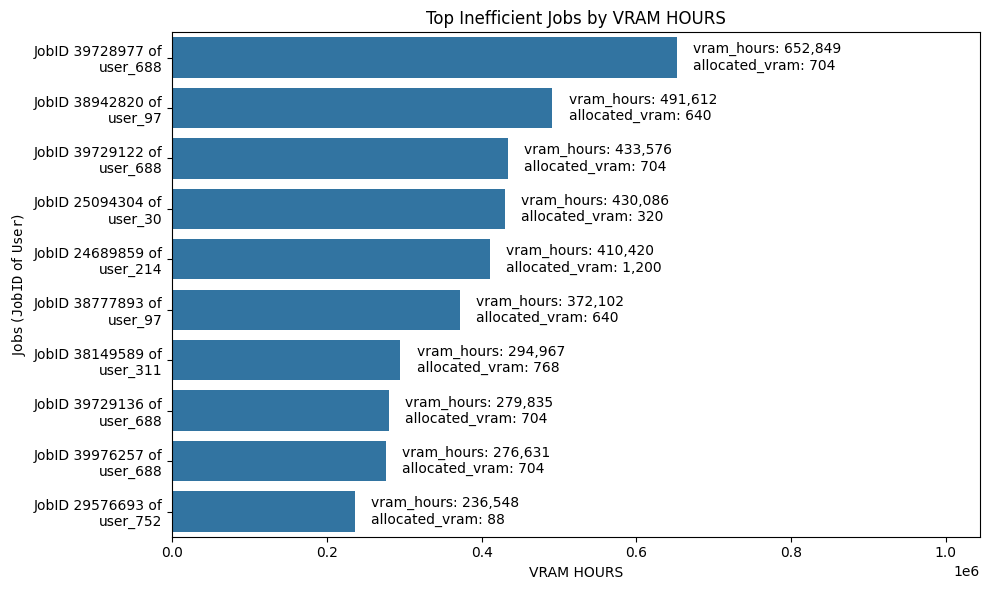

In [ ]:
inefficient_jobs_vram_hours = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=MetricsDataFrameNameEnum.JOBS,
    sorting_key="vram_hours",
    ascending=False,  # Sort by vram_hours in descending order
    filter_criteria={
        "vram_hours": {"min": 80 * 24, "inclusive": True},  # VRAM-hours threshold for identifying inefficient jobs
    },
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient Jobs by VRAM-hours:")
display(inefficient_jobs_vram_hours.head(10))

# Plot top inefficient jobs by VRAM-hours, with VRAM-hours as labels
jobs_with_metrics_visualizer = JobsWithMetricsVisualizer(inefficient_jobs_vram_hours.head(10))
jobs_with_metrics_visualizer.visualize(
    column="vram_hours", bar_label_columns=["vram_hours", "allocated_vram"], figsize=(10, 6)
)

### <a id='toc1_2_3_'></a>[User Metrics](#toc0_)

In [ ]:
users_with_metrics

,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_requested_vram_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_requested_vram_efficiency,expected_value_gpu_count,vram_hours
0,user_01,367,784.686667,account_288,<NA>,<NA>,0.0,0.0,1.009158,1.927880e+04
1,user_02,43,319.341389,account_252,<NA>,<NA>,0.0,0.0,1.000000,1.516841e+04
2,user_03,280,4482.832222,account_05,<NA>,<NA>,0.0,0.0,3.709249,1.023562e+06
3,user_04,2,2.2875,account_125,<NA>,<NA>,0.0,0.0,1.000000,1.830000e+02
4,user_05,66,283.2975,account_111,<NA>,<NA>,0.0,0.0,1.000000,8.409817e+03
...,...,...,...,...,...,...,...,...,...,...
904,user_994,46,341.176944,account_68,<NA>,<NA>,0.0,<NA>,1.000000,5.862036e+03
905,user_995,4,6.508056,account_111,<NA>,<NA>,0.0,0.0,1.000000,3.971172e+02
906,user_997,49,278.365278,account_116,<NA>,<NA>,0.0,0.0,1.724172,1.875558e+04
907,user_998,1,0.5075,account_205,<NA>,<NA>,0.0,<NA>,1.000000,8.120000e+00


#### <a id='toc1_2_3_1_'></a>[Find Inefficient Users based on `vram_hours`](#toc0_)


Top inefficient users by VRAM-hours:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_requested_vram_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_requested_vram_efficiency,expected_value_gpu_count,vram_hours
16,user_1005,367,65862.13,account_304,<NA>,<NA>,0.0,0.0,6.327014,1.157176e+07
802,user_892,76,30677.966667,account_195,<NA>,<NA>,0.0,0.0,3.999903,4.928355e+06
642,user_732,115239,166749.4675,account_98,<NA>,<NA>,0.0,0.0,1.000000,2.166964e+06
597,user_688,43,2981.844444,account_113,<NA>,<NA>,0.0,0.0,63.069883,1.956617e+06
254,user_334,101,2537.676389,account_265,<NA>,<NA>,0.0,<NA>,55.957628,1.916344e+06
333,user_413,642,20399.521111,account_272,<NA>,<NA>,0.0,<NA>,6.954138,1.695459e+06
209,user_288,1018,49064.111389,account_94,<NA>,<NA>,0.0,0.0,3.272305,1.551612e+06
659,user_752,1735,20756.176944,account_134,<NA>,<NA>,0.0,<NA>,7.629226,1.347005e+06
2,user_03,280,4482.832222,account_05,<NA>,<NA>,0.0,0.0,3.709249,1.023562e+06
880,user_97,99,1947.043056,account_205,<NA>,<NA>,0.0,0.0,7.501314,9.385108e+05


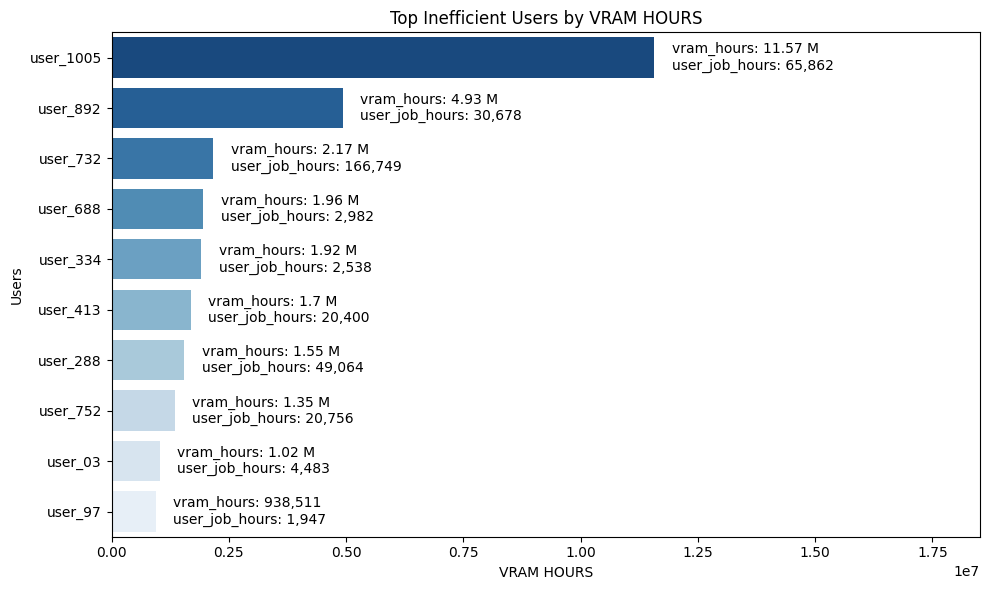

In [ ]:
inefficient_users_vram_hours = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=MetricsDataFrameNameEnum.USERS,
    sorting_key="vram_hours",
    ascending=False,  # Sort by vram_hours in descending order
    filter_criteria={
        "vram_hours": {"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
        "job_count": {"min": 5, "inclusive": True},  # Job count threshold for identifying inefficient users
    },
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient users by VRAM-hours:")
display(inefficient_users_vram_hours.head(10))


# Plot top inefficient users by VRAM-hours, with VRAM-hours as labels
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_vram_hours.head(10))
users_with_metrics_visualizer.visualize(
    column="vram_hours", bar_label_columns=["vram_hours", "user_job_hours"], figsize=(10, 6)
)

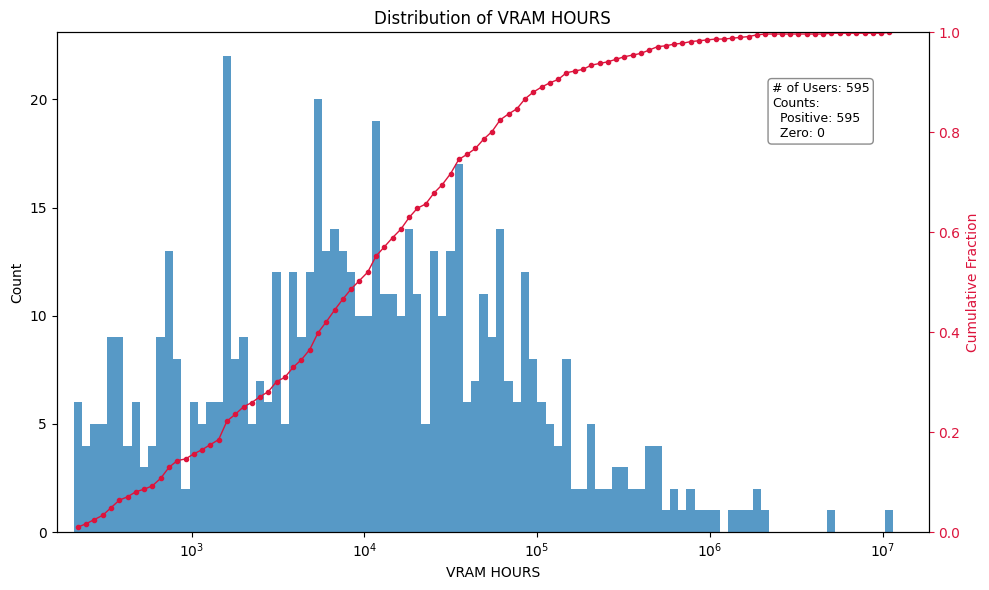

In [ ]:
distro_visualizer = UsersWithMetricsVisualizer(inefficient_users_vram_hours)
distro_visualizer.visualize_metric_distribution(
    output_dir_path=USERS_VISUALIZATION_DATA_DIR, column="vram_hours", figsize=(10, 6)
)

### <a id='toc1_2_4_'></a>[PI Group Metrics](#toc0_)

In [ ]:
pi_accounts_with_metrics

,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,avg_alloc_vram_efficiency_score,avg_requested_vram_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_requested_vram_efficiency,expected_value_gpu_count
0,account_195,157,31825.266667,3,5.029849e+06,<NA>,<NA>,0.0,0.0,3.999101
1,account_25,59,775.582222,1,3.353134e+04,<NA>,<NA>,0.0,0.0,4.971382
2,account_160,11,16.424444,1,2.090100e+02,<NA>,<NA>,0.0,<NA>,1.000000
3,account_245,8,63.049444,2,1.302067e+03,<NA>,<NA>,0.0,<NA>,1.811619
4,account_217,16,73.564167,2,4.501805e+03,<NA>,<NA>,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
281,account_233,4,98.698889,1,6.018791e+03,<NA>,<NA>,0.0,<NA>,4.000000
282,account_04,2,0.65,1,5.200000e+01,<NA>,<NA>,0.0,0.0,1.000000
283,account_278,13,11.868333,3,7.423100e+02,<NA>,<NA>,0.0,0.0,3.027275
284,account_301,132,771.995556,3,5.505221e+04,<NA>,<NA>,0.0,0.0,1.006600


#### <a id='toc1_2_4_1_'></a>[Find Inefficient PIs based on `vram_hours`](#toc0_)


Top inefficient PI Groups by VRAM-Hours:


,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,avg_alloc_vram_efficiency_score,avg_requested_vram_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_requested_vram_efficiency,expected_value_gpu_count
213,account_304,374,66835.228889,3,1.187954e+07,<NA>,<NA>,0.0,0.0,6.266583
0,account_195,157,31825.266667,3,5.029849e+06,<NA>,<NA>,0.0,0.0,3.999101
257,account_265,394,9896.428889,6,2.804868e+06,<NA>,<NA>,0.0,<NA>,40.496052
140,account_134,4490,93312.961111,6,2.461069e+06,<NA>,<NA>,0.0,<NA>,5.160440
104,account_272,5373,46900.354444,11,2.245922e+06,<NA>,<NA>,0.0,0.0,5.606529
204,account_98,115239,166749.4675,1,2.166964e+06,<NA>,<NA>,0.0,0.0,1.000000
181,account_113,60,3013.761944,6,1.958376e+06,<NA>,<NA>,0.0,0.0,63.016433
231,account_94,1109,49827.532222,5,1.569815e+06,<NA>,<NA>,0.0,0.0,3.258149
178,account_50,3037,15999.991111,23,1.525129e+06,<NA>,<NA>,0.0,0.0,3.229896
38,account_17,167,10454.798889,4,1.265637e+06,<NA>,<NA>,0.0,0.0,5.169539


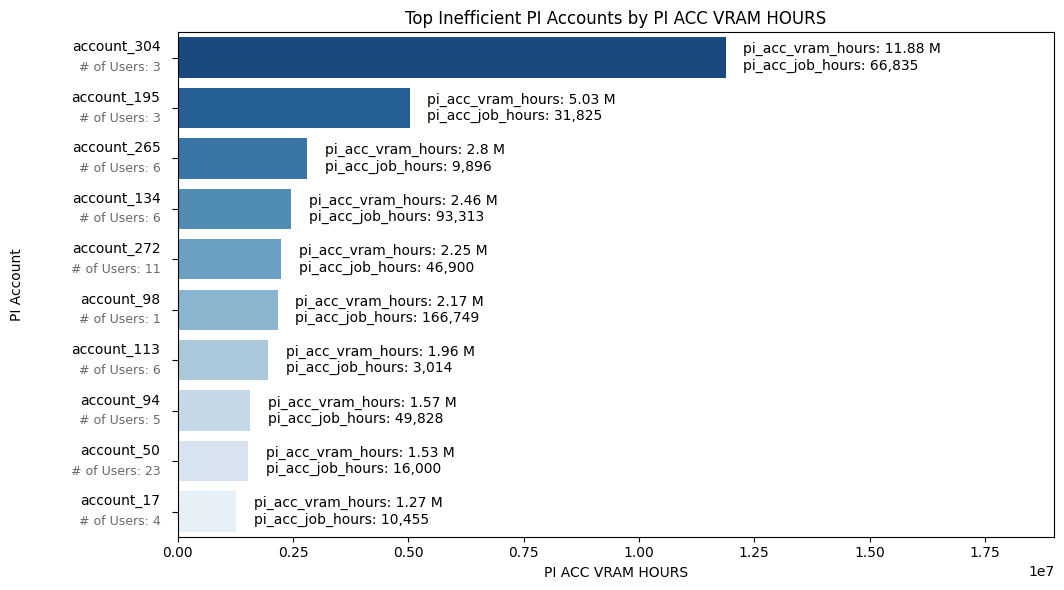

In [ ]:
inefficient_pis_vram_hours = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=MetricsDataFrameNameEnum.PI_GROUPS,
    sorting_key="pi_acc_vram_hours",
    ascending=False,
    filter_criteria={
        "pi_acc_vram_hours": {"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a PI account
    },
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient PI Groups by VRAM-Hours:")
display(inefficient_pis_vram_hours.head(10))

# Plot top inefficient PI Groups by VRAM-hours, with VRAM-hours as labels
pi_accounts_with_metrics_visualizer = PIGroupsWithMetricsVisualizer(inefficient_pis_vram_hours.head(10))
pi_accounts_with_metrics_visualizer.visualize(
    column="pi_acc_vram_hours", bar_label_columns=["pi_acc_vram_hours", "pi_acc_job_hours"], figsize=(10, 6)
)